In [43]:
import ROOT as rt
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import awkward
import numpy as np
import time
from matplotlib import pyplot as plt
sys.path.append('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph
import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

print(sys.version)


3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


In [4]:
%%time

fpath = OrderedDict()
tree = OrderedDict()
path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall18/v1/v8/normalized/' 

fpath['ee, m_{s} = 0.4 GeV, c#tau = 500 mm'] = path + 'ggH_HToSS_SToEE_ms0p4_pl500_1pb_weighted.root'
fpath['ee, m_{s} = 1 GeV, c#tau = 100 mm'] = path + 'ggH_HToSS_SToEE_ms0p1_pl100_1pb_weighted.root'
fpath['ee, m_{s} = 1 GeV, c#tau = 500 mm'] = path + 'ggH_HToSS_SToEE_ms0p1_pl500_1pb_weighted.root'
fpath['#pi^{0}#pi^{0}, m_{s} = 1 GeV, c#tau = 100 mm'] = path + 'ggH_HToSS_SToPi0Pi0_ms1_pl100_1pb_weighted.root'
fpath['#pi^{0}#pi^{0}, m_{s} = 1 GeV, c#tau= 500 mm'] = path + 'ggH_HToSS_SToPi0Pi0_ms1_pl500_1pb_weighted.root'
fpath['#pi^{+}#pi^{-}, m_{s} = 1 GeV, c#tau = 500 mm'] = path + 'ggH_HToSS_SToPiPlusPiMinus_ms1_pl500_1pb_weighted.root'
fpath['k^{+}k^{-}, m_{s} = 1.5 GeV, c#tau = 500 mm'] = path + 'ggH_HToSS_SToKPlusKMinus_ms1p5_pl500_1pb_weighted.root'
fpath['dd, m_{s} = 1 GeV, c#tau = 1000 mm'] = path +  'ggH_HToSSTobbbb_ms1_pl1000_1pb_weighted.root'
fpath['#tau#tau, m_{s} = 7 GeV, c#tau = 1000 mm'] = path +  'ggH_HToSSTo4Tau_MH-125_MS-7_ctau-1000_TuneCP5_13TeV-powheg-pythia8_1pb_weighted.root'
fpath['bb, m_{s} = 15 GeV, c#tau = 1000 mm'] = path +  'ggH_HToSSTobbbb_MH-125_MS-15_ctau-1000_TuneCP5_13TeV-powheg-pythia8_1pb_weighted.root'
fpath['#tau#tau, m_{s} = 15 GeV, c#tau = 1000 mm'] = path +  'ggH_HToSSTo4Tau_MH-125_MS-15_ctau-1000_TuneCP5_13TeV-powheg-pythia8_1pb_weighted.root'
fpath['dd, m_{s} = 15 GeV, c#tau = 1000 mm'] = path +  'ggH_HToSSTodddd_MH-125_MS-15_ctau-1000_TuneCP5_13TeV-powheg-pythia8_1pb_weighted.root'

for k, v in fpath.items():
    print (k, v)
    root_dir = uproot.open(v) 
    tree[k] = root_dir['MuonSystem']
    print(len(tree[k]))

ee, m_{s} = 0.4 GeV, c#tau = 500 mm /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall18/v1/v8/normalized/ggH_HToSS_SToEE_ms0p4_pl500_1pb_weighted.root
999700
ee, m_{s} = 1 GeV, c#tau = 100 mm /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall18/v1/v8/normalized/ggH_HToSS_SToEE_ms0p1_pl100_1pb_weighted.root
998500
ee, m_{s} = 1 GeV, c#tau = 500 mm /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall18/v1/v8/normalized/ggH_HToSS_SToEE_ms0p1_pl500_1pb_weighted.root
999400
#pi^{0}#pi^{0}, m_{s} = 1 GeV, c#tau = 100 mm /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall18/v1/v8/normalized/ggH_HToSS_SToPi0Pi0_ms1_pl100_1pb_weighted.root
999400
#pi^{0}#pi^{0}, m_{s} = 1 GeV, c#tau= 500 mm /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall18/v1/v8/normalized/ggH_HToSS_SToPi0Pi0_ms1_pl500_1pb_we

In [5]:
# Helper Functions

In [6]:
import math
def deltaPhi( phi1,  phi2):
    dphi = phi1 - phi2
    while (dphi > math.pi):
        dphi -= 2 * math.pi
    while (dphi <= -math.pi):
        dphi += 2 * math.pi
    return dphi
def deltaR(eta1, phi1, eta2, phi2):
    dphi = deltaPhi(phi1,phi2)
    deta = eta1 - eta2
    return (dphi * dphi + deta * deta)**0.5

In [7]:
# Load variables

In [11]:
JET_PT_CUT = 10.0
MUON_PT_CUT = 20.0
jetPt_cut = 50
cluster_index = '3'
gLLP_decay_vertex_r = {}
cscRechitCluster3_match_gLLP_decay_r = {}
gLLP_decay_vertex_z = {}
cscRechitCluster3_match_gLLP_decay_z = {}
weight = {}
pileupWeight = {}
evtNum = {}
runNum = {}
lumiSec = {}
sel_ev = {}
gLLP_beta = {}
gLLP_csc = {}
gLLP_ctau = {}
gLLP_eta = {}
cscRechitClusterX = {}
cscRechitClusterY = {}
cscRechitClusterZ = {}
cscRechitClusterPhi = {}
cscRechitClusterEta = {}
cscRechitCluster3NStation = {}
cscRechitClusterNChamber = {}
cscRechitClusterSize = {}
cscRechitClusterAvgStation = {}
cscRechitCluster3XSpread= {}
cscRechitCluster3YSpread = {}
cscRechitClusterSize = {}
cscRechitCluster3Eta = {}
cscRechitCluster3AvgStation5 = {}
weight_ctau = {}
cluster_match_eta = {}
gLLP_e = {}
cluster_match_energy = {}
cscRechitCluster3_match_gLLP_pt = {}
cscRechitCluster3Z = {}

for k, T in tree.items():
########### SELECTION: CLUSTERS ############
    sel_rechitcluster = T.array('cscRechitCluster' + cluster_index + '_match_gLLP_csc') == 1
    sum_sel_rechitcluster = sel_rechitcluster.any()
#     me1112_veto = 0
#     sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus11') == 0)
#     sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus12') == 0)
#     sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus11') == 0)
#     sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus12') == 0)

#     sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_MB1Seg_0p4') == me1112_veto)
#     sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_RE12_0p4') == me1112_veto)
#     sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_RB1_0p4') == me1112_veto)
#     sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'TimeSpread') <= 20)
    
#     sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'JetVetoPt') < JET_PT_CUT)
#     sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'MuonVetoPt') < MUON_PT_CUT)
#     sel_rechitcluster = np.logical_and(sel_rechitcluster, np.logical_and(T.array('cscRechitCluster' + cluster_index + 'TimeTotal') < 12.5, T.array('cscRechitCluster' + cluster_index + 'TimeTotal') > -5.0))
        
########### SELECTION: JETS ############
   
    sel_jet = np.logical_and(T.array('jetPt') > jetPt_cut, np.abs(T.array('jetEta')) < 2.4 )


########### SELECTION: EVENTS ############
   

########### SELECTION: EVENTS ############
    sel_ev[k] = (np.sum(T.array('gLLP_csc'),axis = 1) > 0)
    sel_ev[k]  = np.logical_and(sel_ev[k],sel_rechitcluster.sum() == 1)
#     sel_ev[k]   = np.logical_and(sel_ev[k], T['HLTDecision'].array()[:,310]) # MET trigger
#     sel_ev[k]  = np.logical_and(sel_ev[k], T.array('category') == 0)
#     sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('met') > 200)
#     sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('nLeptons') == 0)
#     sel_ev[k] = np.logical_and(sel_ev[k] , sel_jet.sum()>=1)
#     sel_ev[k] = np.logical_and(sel_ev[k],T.array('Flag2_all'))

########### BRANCHES ############

   ##### event variables ##### 

    t1 = T.array('gLLP_ctau')[:,0][sel_ev[k]][np.logical_and((np.logical_not(np.isnan((T.array('gLLP_ctau')[:,0][sel_ev[k]])))),
                           (np.logical_not(np.isnan((T.array('gLLP_ctau')[:,1][sel_ev[k]])))))] #selected for RW

    t2 = (T.array('gLLP_ctau')[:,1])[sel_ev[k]][np.logical_and((np.logical_not(np.isnan((T.array('gLLP_ctau')[:,0][sel_ev[k]])))),
                                 (np.logical_not(np.isnan((T.array('gLLP_ctau')[:,1][sel_ev[k]])))))] #selected for RW
    tau_old = 100
    tau_new = 50
    expIn = (t1 + t2) * ((1/tau_old) - (1/tau_new))
    weight1 = (tau_old/tau_new)**2
    weight2 = np.exp(expIn)
    weight_ctau[k] = weight1 * weight2 


    gLLP_beta[k] = T.array('gLLP_beta')[sel_ev[k]]
    gLLP_csc[k] = T.array('gLLP_csc')[sel_ev[k]]
    gLLP_eta[k]= T.array('gLLP_eta')[T.array('gLLP_csc') == 1]  
    gLLP_e[k] = T.array('gLLP_e')[T.array('gLLP_csc') == 1] 
    gLLP_decay_vertex_r[k] = T.array('gLLP_decay_vertex_r')[T.array('gLLP_csc') == 1] 
    gLLP_decay_vertex_z[k] = T.array('gLLP_decay_vertex_z')[T.array('gLLP_csc') == 1] 
    weight[k] = T.array('weight')[sel_ev[k]]
    evtNum[k] = T.array('evtNum')[sel_ev[k]] 
    runNum[k] = T.array('runNum')[sel_ev[k]]
    lumiSec[k] = T.array('lumiSec')[sel_ev[k]]
    
       #### Calculate Acceptance and CEff #### 
    UWAccep = (np.count_nonzero(sel_ev[k])) / len(sel_ev[k]) #acceptance for UW
    clusterMatched = (np.count_nonzero(sum_sel_rechitcluster)) / len(sum_sel_rechitcluster) #events w/ a cluster matched to LLP
    ClusteringEff = clusterMatched / UWAccep

    if k[:2] == 'mc':
        pileupWeight[k] = T.array('pileupWeight')[sel_ev[k]]
    else:                               
        pileupWeight[k] = np.ones(weight[k].shape, dtype=bool)
    if k[:2] == 'mc':
        weight[k] = weight[k]*lumi
    
     ##### cluster-level variables ####  

    cscRechitClusterPhi[k] = T.array('cscRechitCluster' + cluster_index + 'Phi')[sel_rechitcluster][sel_ev[k]].flatten()
    cscRechitCluster3NStation[k] = T.array('cscRechitCluster' + cluster_index + 'NStation')[sel_rechitcluster][sel_ev[k]].flatten()
    cscRechitCluster3Eta = T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_rechitcluster][sel_ev[k]].flatten()
    cscRechitClusterSize[k] = T.array('cscRechitCluster' + cluster_index + 'Size')[sel_rechitcluster][sel_ev[k]].flatten()
    cscRechitClusterX[k] = T.array('cscRechitCluster' + cluster_index + 'X')[sel_rechitcluster][sel_ev[k]].flatten()
    cscRechitCluster3XSpread[k] = T.array('cscRechitCluster' + cluster_index + 'XSpread')[sel_rechitcluster][sel_ev[k]].flatten()
    cscRechitCluster3YSpread[k] = T.array('cscRechitCluster' + cluster_index + 'YSpread')[sel_rechitcluster][sel_ev[k]].flatten()
    cscRechitClusterY[k] = T.array('cscRechitCluster' + cluster_index + 'Y')[sel_rechitcluster][sel_ev[k]].flatten()
    cscRechitClusterZ[k] = T.array('cscRechitCluster' + cluster_index + 'Z')[sel_rechitcluster][sel_ev[k]].flatten()
    cscRechitClusterEta[k] = T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_rechitcluster][sel_ev[k]].flatten()
    cscRechitClusterPhi[k] = T.array('cscRechitCluster' + cluster_index + 'Phi')[sel_rechitcluster][sel_ev[k]].flatten()
    cscRechitClusterAvgStation[k] = T.array('cscRechitCluster' + cluster_index + 'AvgStation5')[sel_rechitcluster][sel_ev[k]].flatten()
    cscRechitClusterSize[k] =  T.array('cscRechitCluster' + cluster_index + 'Size')[sel_rechitcluster][sel_ev[k]].flatten()
    cscRechitCluster3Z[k] = T.array('cscRechitCluster' + cluster_index + 'Z')[sel_rechitcluster][sel_ev[k]].flatten()
    cscRechitCluster3_match_gLLP_decay_z[k] = (T.array('cscRechitCluster' + cluster_index + '_match_gLLP_decay_z'))[sel_rechitcluster][sel_ev[k]].flatten()
    cluster_match_eta[k] = T.array('cscRechitCluster' + cluster_index + '_match_gLLP_eta')[sel_rechitcluster][sel_ev[k]].flatten()
    cscRechitCluster3_match_gLLP_pt[k] = (T.array('cscRechitCluster' + cluster_index + '_match_gLLP_pt'))[sel_rechitcluster][sel_ev[k]].flatten()
    cluster_match_energy[k] = ((T.array('cscRechitCluster' + cluster_index + '_match_gLLP_e'))[sel_rechitcluster])
    cscRechitCluster3_match_gLLP_decay_r[k] = ((T.array('cscRechitCluster' + cluster_index + '_match_gLLP_decay_r'))[sel_rechitcluster])
    cscRechitClusterEta[k] = np.abs(cscRechitClusterEta[k])
    cscRechitClusterAvgStation[k] = np.abs(cscRechitClusterAvgStation[k])


In [12]:
## 1D histograms

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: ps file c.ps has been created


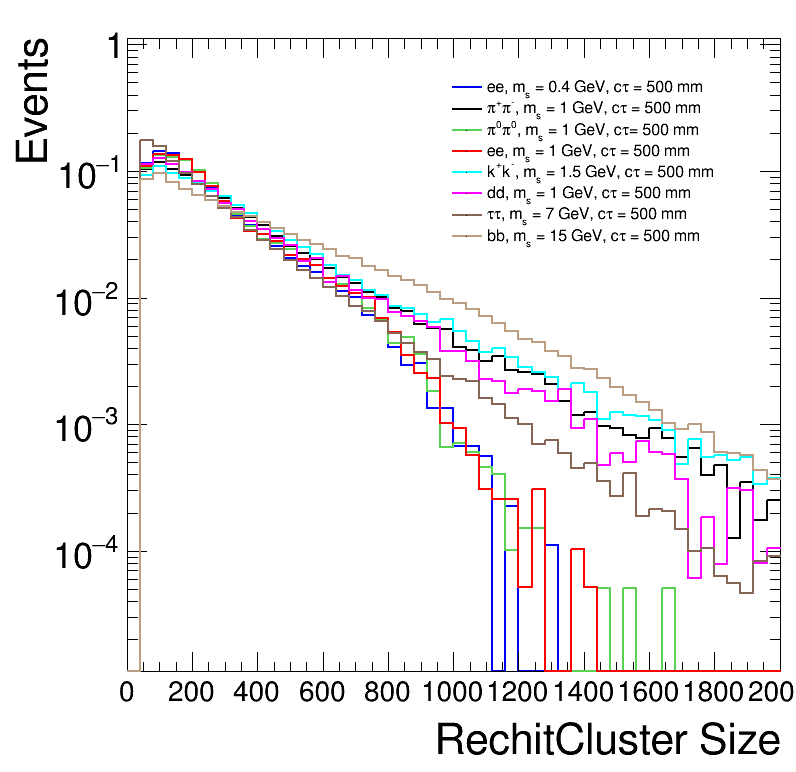

In [45]:
####Reweighted Graphs ####
c = rt.TCanvas('c','c', 800, 800)
h = {}
leg = rt.TLegend(0.77, 0.68, 0.56, 0.9) 
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetTextFont(42)
UWkeyLst = ['ee, m_{s} = 0.4 GeV, c#tau = 500 mm','#pi^{+}#pi^{-}, m_{s} = 1 GeV, c#tau = 500 mm','#pi^{0}#pi^{0}, m_{s} = 1 GeV, c#tau= 500 mm', 
        'ee, m_{s} = 1 GeV, c#tau = 500 mm','k^{+}k^{-}, m_{s} = 1.5 GeV, c#tau = 500 mm']
colorLst = [2, 0, 3, 1, 7]
count = 0
for a in UWkeyLst:
    h[a] = create_TH1D(cscRechitClusterSize[a], axis_title = ['RechitCluster Size', 'Events'], name = a, binning = [50, 0, 2000])
    h[a].SetLineColor(std_color_list[colorLst[count]])
    h[a].GetYaxis().SetRangeUser(0.1, 10000)
    leg.AddEntry(h[a], a)
    h[a].GetXaxis().SetLabelSize(0.04)
    h[a].DrawNormalized('same hist') 
    count += 1
RWkeyLst = ['dd, m_{s} = 1 GeV, c#tau = 1000 mm','#tau#tau, m_{s} = 7 GeV, c#tau = 1000 mm','bb, m_{s} = 15 GeV, c#tau = 1000 mm']
RWlegend = ['dd, m_{s} = 1 GeV, c#tau = 500 mm','#tau#tau, m_{s} = 7 GeV, c#tau = 500 mm','bb, m_{s} = 15 GeV, c#tau = 500 mm']
count1 = 0
colorCount = 4
for j in RWkeyLst:
    h[j] = create_TH1D(cscRechitClusterSize[j], axis_title = ['RechitCluster Y Spread [cm]', 'Events'], name = j, binning = [50, 0, 2000], weights = weight_ctau[j])
    h[j].SetLineColor(std_color_list[colorCount])
    h[j].GetYaxis().SetRangeUser(0.01, 10000)
    leg.AddEntry(h[j], RWlegend[count1])
    h[j].GetXaxis().SetLabelSize(0.04)
    h[j].DrawNormalized('same hist') 
    colorCount += 1
    count1 += 1
leg.Draw()
c.SetLogy()
c.Draw()
c.SaveAs()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


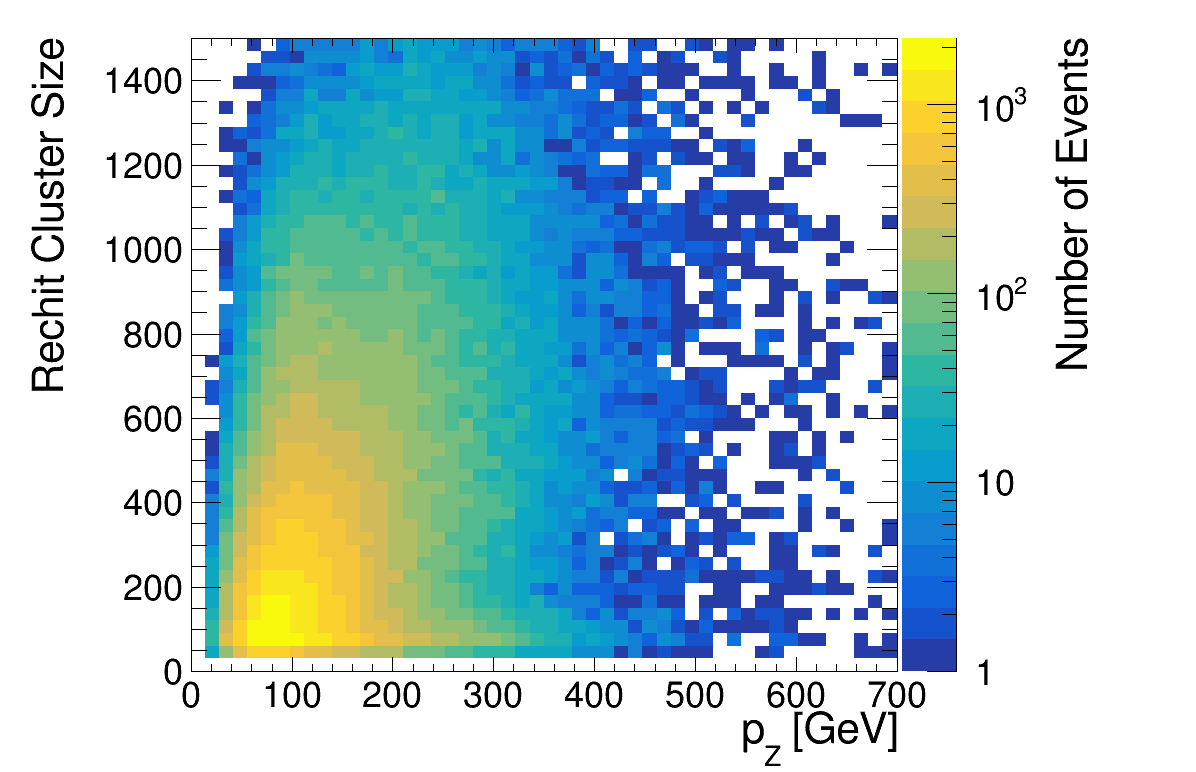

In [46]:
####2D CEff####
start_t = time.time()
c = rt.TCanvas('c','c', 1200, 800)
h = {}
momentumZ = {}
leg = rt.TLegend(0.36, 0.79, 0.5, 0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetTextFont(42)
keys = ['ee, m_{s} = 0.4 GeV, c#tau = 500 mm','ee, m_{s} = 1 GeV, c#tau = 500 mm','#pi^{0}#pi^{0}, m_{s} = 1 GeV, c#tau= 500 mm',
       '#pi^{+}#pi^{-}, m_{s} = 1 GeV, c#tau = 500 mm',  'k^{+}k^{-}, m_{s} = 1.5 GeV, c#tau = 500 mm', 'dd, m_{s} = 1 GeV, c#tau = 1000 mm',
       '#tau#tau, m_{s} = 7 GeV, c#tau = 1000 mm','bb, m_{s} = 15 GeV, c#tau = 1000 mm']
  
k = 'bb, m_{s} = 15 GeV, c#tau = 1000 mm' 
momentumZ[k] = (cscRechitCluster3_match_gLLP_pt[k].flatten())*np.sinh(cluster_match_eta[k].flatten())
h[k] = create_TH2D((np.column_stack((momentumZ[k],cscRechitClusterSize[k]))), 
                   axis_title=['p_{Z} [GeV]','Rechit Cluster Size', 'Number of Events'], name = k, binning=[50, 0, 700, 50, 0, 1500])
#h[k] = h[k].ProfileX()
h[k].Draw('colz')
c.SetLogz()
c.SetRightMargin(0.25)
rt.gPad.Update()
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: ee, m_{s} = 0.4 GeV, c#tau = 500 mm (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: #pi^{+}#pi^{-}, m_{s} = 1 GeV, c#tau = 500 mm (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: #pi^{0}#pi^{0}, m_{s} = 1 GeV, c#tau= 500 mm (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: ee, m_{s} = 1 GeV, c#tau = 500 mm (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: k^{+}k^{-}, m_{s} = 1.5 GeV, c#tau = 500 mm (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: dd, m_{s} = 1 GeV, c#tau = 1000 mm (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: #tau#tau, m_{s} = 7 GeV, c#tau = 1000 mm (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: bb, m_{s} = 15 GeV, c#tau = 1000 mm (Potential memory leak)

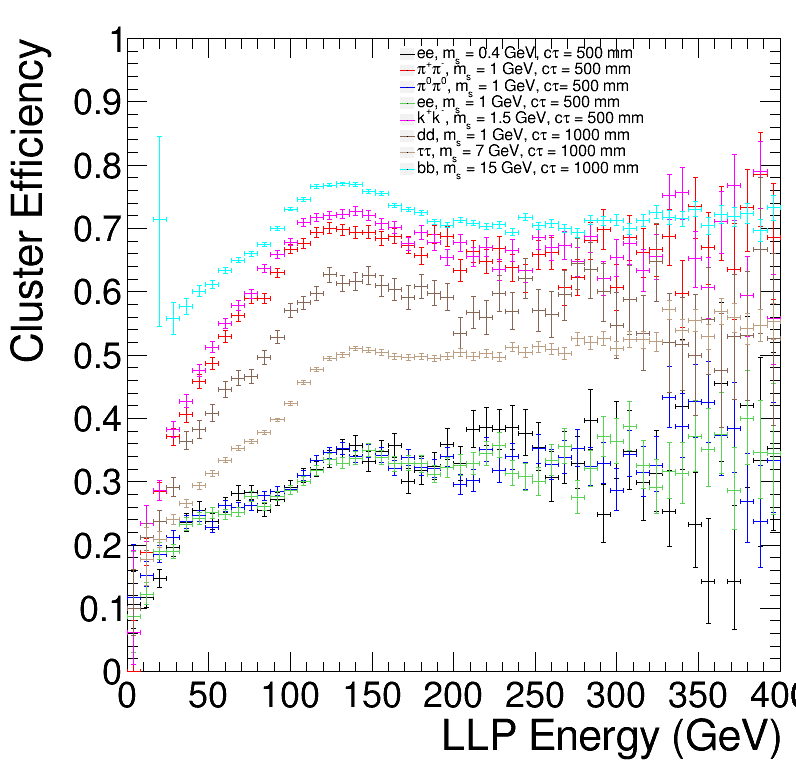

In [47]:
####CEff Vs. Energy####
start_t = time.time()
c = rt.TCanvas('c','c', 800, 800)
h = {}
j = {}
pEff1 = {}
leg = rt.TLegend(0.5, 0.77, 0.6, 0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetTextFont(42)
keys = ['ee, m_{s} = 0.4 GeV, c#tau = 500 mm', '#pi^{+}#pi^{-}, m_{s} = 1 GeV, c#tau = 500 mm','#pi^{0}#pi^{0}, m_{s} = 1 GeV, c#tau= 500 mm', 
       'ee, m_{s} = 1 GeV, c#tau = 500 mm','k^{+}k^{-}, m_{s} = 1.5 GeV, c#tau = 500 mm', 'dd, m_{s} = 1 GeV, c#tau = 1000 mm',
      '#tau#tau, m_{s} = 7 GeV, c#tau = 1000 mm','bb, m_{s} = 15 GeV, c#tau = 1000 mm']
i = 0
for k in keys: 
    cluster_match_energy[k] = np.abs(cluster_match_energy[k])
    gLLP_e[k] = np.abs(gLLP_e[k])   
    h[k] = create_TH1D(cluster_match_energy[k].flatten(), axis_title = ['LLP Energy (GeV)', 'Cluster Efficiency'], name = k, binning = [50, 0, 400])
    j[k] = create_TH1D(gLLP_e[k].flatten(), axis_title = ['LLP Energy (GeV)', 'Cluster Efficiency'], name = k, binning = [50, 0, 400])
    pEff1[k] = rt.TEfficiency(h[k], j[k])
    leg.AddEntry(pEff1[k], keys[i])
    pEff1[k].SetLineColor(std_color_list[i])
    pEff1[k].Draw('AP' if i == 0 else 'P same')
    rt.gPad.Update()
    pEff1[k].GetPaintedGraph().GetHistogram().GetXaxis().SetLimits(0, 400)
    pEff1[k].GetPaintedGraph().SetMaximum(1)
    pEff1[k].GetPaintedGraph().SetMinimum(0)
    i += 1
##to add geometry of the detector##
#     ymax = pEff1[k].GetPaintedGraph().GetHistogram().GetMaximum()
#     ymin = pEff1[k].GetPaintedGraph().GetHistogram().GetMinimum()
#     xmin = pEff1[k].GetPaintedGraph().GetHistogram().GetXaxis().GetXmin()
#     xmax = pEff1[k].GetPaintedGraph().GetHistogram().GetXaxis().GetXmax()
#     if r:
#         l = rt.TLine(350,ymin, 350, ymax)
#         l.SetLineWidth(2)
#         l.SetLineStyle(2)
#         l.Draw()
#         text = rt.TLatex()
#         text.SetTextSize(0.04)
#         text.DrawLatex(150, ymax*0.94, “Inner ring”)
#         text.DrawLatex(400, ymax*0.94, “Outer ring”)
#else:
#     boxes = []
#     boxes.append(rt.TBox(xmin, ymin, 568, ymax)) #in front of ME11
#     boxes.append(rt.TBox(632, ymin, 671, ymax)) #between ME11 and ME12
#     boxes.append(rt.TBox(724, ymin, 789, ymax)) #between ME12 and station2
#     boxes.append(rt.TBox(849, ymin, 911, ymax)) #between station2 and station3
#     boxes.append(rt.TBox(970, ymin, 1002, ymax)) #between station3 and station4
#     boxes.append(rt.TBox(1073, ymin, xmax, ymax)) #beyond CMS
#     for b in boxes:
#         b.SetFillColor(15)
#         b.SetFillStyle(3001)
#         b.Draw('same')
#     l = rt.TLatex()
#     l.SetTextSize(0.08)
#     l.SetTextColor(12)
#     l.SetTextAngle(90)
#     l.DrawLatex(550, ymax*0.7, 'Steel')
#     l2 = rt.TLatex()
#     l2.SetTextSize(0.06)
#     l2.SetTextColor(13)
#     l2.SetTextAngle(90)
#     l2.DrawLatex(1110, ymax*0.5, 'Beyond CMS')
#     text = rt.TLatex()
#     text.SetTextSize(0.04)
#     text.DrawLatex(570, ymax*1.01, 'ME1/1')
#     text.DrawLatex(660, ymax*1.01, 'ME1/2-3')
#     text.DrawLatex(795, ymax*1.01, 'ME2')
#     text.DrawLatex(920, ymax*1.01, 'ME3')
#     text.DrawLatex(1015, ymax*1.01, 'ME4')
leg.Draw()
c.Draw()
c.SaveAs()